In [1]:
import os
import json
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from analysis import *
from plots import *

%matplotlib inline

with open('config.json') as f:
    config = json.load(f)

In [2]:
output_dir = config['output_dir']
# output_dir = './psd_output/'
output_dir = './lfp_data_v1_output/'

ecephys_structure_acronym = config['analysis_object']['ecephys_structure_acronym']

### Select sessions for analysis

In [3]:
initialize_session_list = False

if initialize_session_list:
    from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

    manifest_path = os.path.join(config['cache_dir'], "manifest.json")
    cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
    sessions = cache.get_session_table()

    filter_dict = {
        'session_type': '',
        'full_genotype': '',
        'ecephys_structure_acronyms': 'VISp'
    }
    filtered_sessions = sessions[
        np.logical_and.reduce([np.array([True if s in x else False for x in sessions[k]]) for k, s in filter_dict.items()])
    ]
    session_list = filtered_sessions.index.to_list()

    session_list_df = {k: v if v else filtered_sessions.loc[session_list, k] for k, v in filter_dict.items()}
    session_list_df = pd.DataFrame(session_list_df, index=pd.Index(session_list, name='session_id'))
    session_list_df.to_csv(os.path.join(output_dir, 'session_list.csv'))

    # Initialize session selection table
    session_list_df = pd.read_csv(os.path.join(output_dir, 'session_list.csv'), index_col='session_id')
    session_selection = session_list_df.copy()
    session_selection['psd good'] = True
    session_selection.to_csv(os.path.join(output_dir, 'session_selection_all.csv'))

In [4]:
# Read session selection
session_selection_file = 'session_selection'
# session_selection_file = 'session_selection_all'

session_selection = pd.read_csv(os.path.join(output_dir, session_selection_file + '.csv'), index_col='session_id')

### Get PSD data from session and probe

In [5]:
psd_ds = {}  # psd from different stimuli
dg_cond_psd_ds = {}  # psd from different conditions in drifting gratings
for session_id in session_selection.index:
    session_dir = os.path.join(output_dir, f'session_{session_id:d}')
    if not (session_selection.loc[session_id, 'psd good'] and os.path.isdir(session_dir)):
        continue
    for probe_dir in os.listdir(session_dir):
        probe_dir = os.path.join(session_dir, probe_dir) if probe_dir.startswith('probe_') else ''
        if os.path.isdir(probe_dir):
            ecephys_structure_acronyms = session_selection.loc[session_id, 'ecephys_structure_acronyms']
            filename = ecephys_structure_acronyms + '_psd_channel_groups.nc'
            psd_ds[session_id] = ds = xr.load_dataset(os.path.join(probe_dir, filename))
            # # correct variable name
            # if 'drifting_grating' in ds:
            #     ds = ds.rename(drifting_grating='drifting_gratings')
            # if 'frequency_drifting_grating' in ds:
            #     ds = ds.rename(frequency_drifting_grating='frequency_drifting_gratings')
            # ds.to_netcdf(os.path.join(probe_dir, filename))
            filename = ecephys_structure_acronyms + '_drifting_gratings_condition_psd.nc'
            dg_cond_psd_ds[session_id] = xr.load_dataset(os.path.join(probe_dir, filename))
            break

#### PSD analysis settings

In [6]:
plt_range = (0, 100.)
freq_range = 200.
aperiodic_mode = 'knee'
dB_threshold = 3.
max_n_peaks = 10
figsize = (3.2, 2.4)

In [18]:
def average_across_sessions(psd_ds, stim):
    # get sessions with stimulus
    stim_ds = [ds for ds in psd_ds.values() if stim in ds]
    print(f'\n{stim}: {len(stim_ds)} sessions')
    if len(stim_ds) == 0:
        return

    # get frequency array
    freq_coord = f'frequency_{stim:s}'
    f_min = []
    f_max = []
    nf = []
    for ds in stim_ds:
        freq = ds.coords[freq_coord]
        f_min.append(freq.min())
        f_max.append(freq.max())
        nf.append(freq.size)
    freq = np.linspace(np.max(f_min), np.min(f_max), np.max(nf))
    interp_freq = {freq_coord: freq}

    # interpolate psd and average across sessions
    stim_psd = []
    stim_sessions = []
    for ds in stim_ds:
        group_id = ds.attrs['center_unit_group_id']
        stim_sessions.append(ds.attrs['session_id'])
        psd = ds[stim].sel(channel=group_id).interp(interp_freq)
        stim_psd.append(10 * np.log10(psd)) # convert to decibels
    stim_psd = xr.concat(stim_psd, dim=pd.Index(stim_sessions, name='session_id')).rename({freq_coord: 'frequency'})
    psd_avg = 10 ** (stim_psd.mean(dim='session_id') / 10) # convert back to power
    return psd_avg

### Show PSD of drifting grating conditions

#### Individual sessions

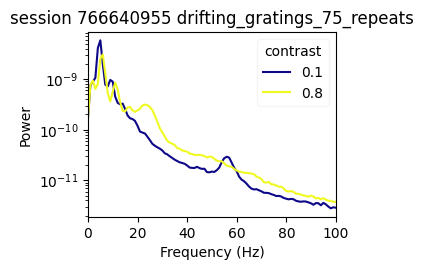

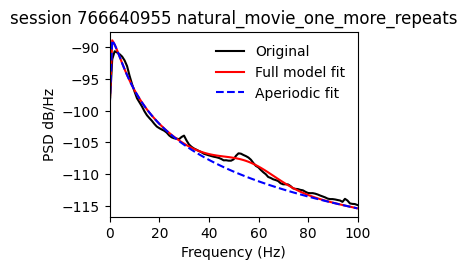

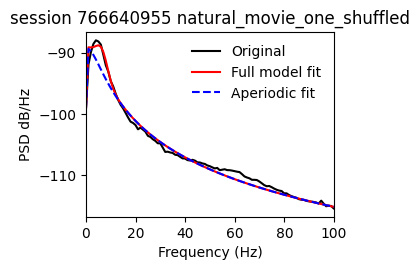

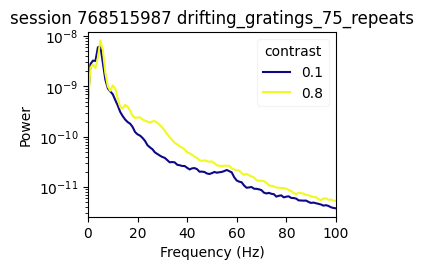

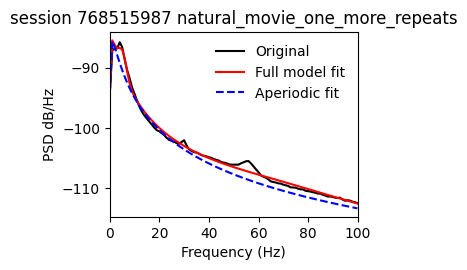

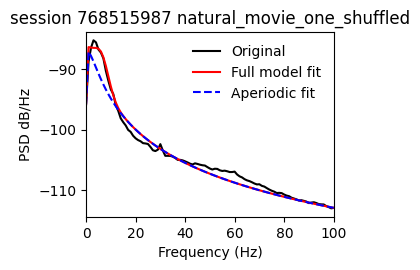

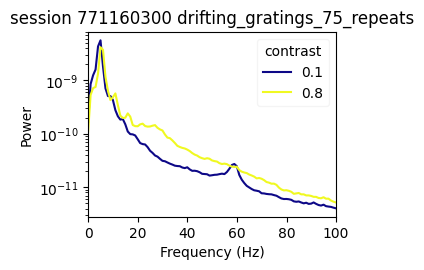

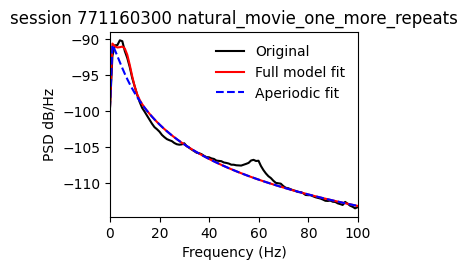

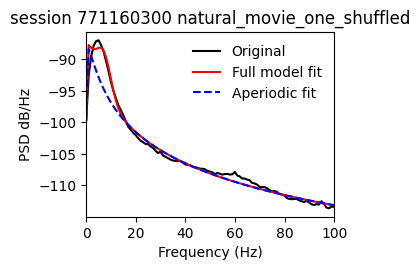

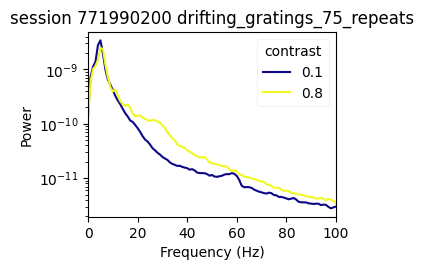

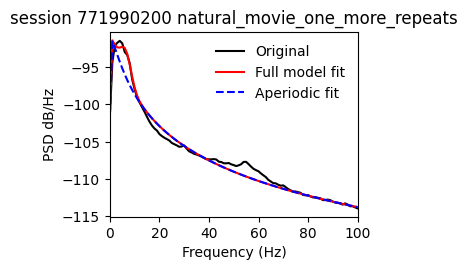

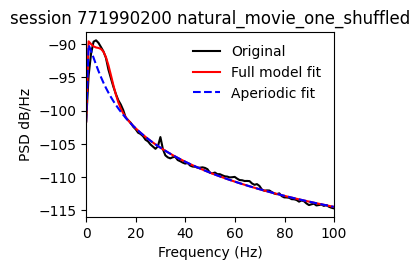

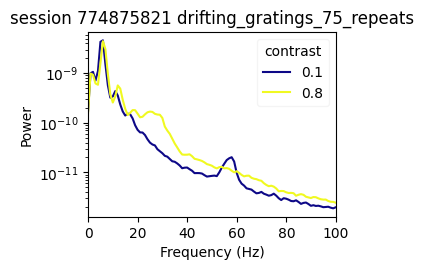

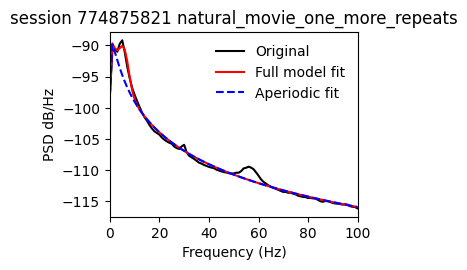

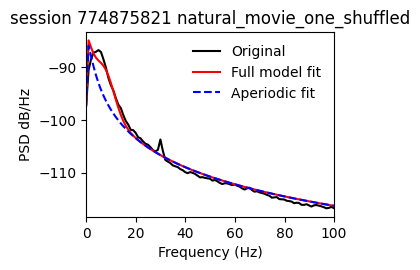

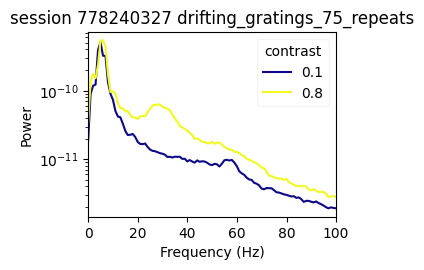

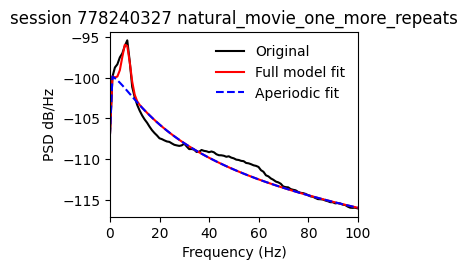

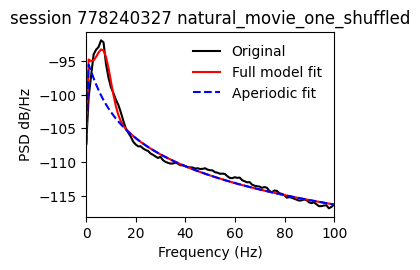

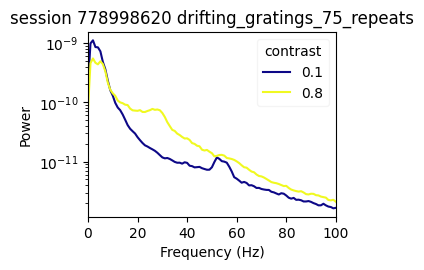

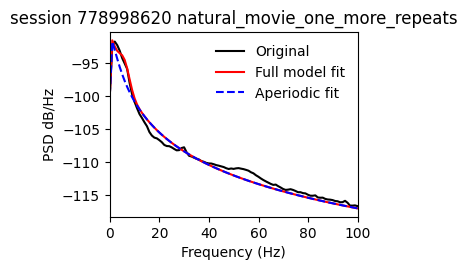

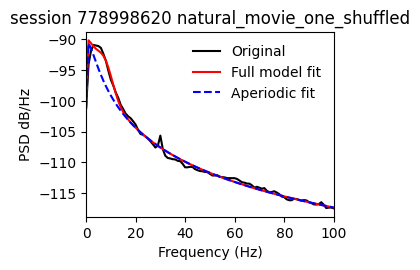

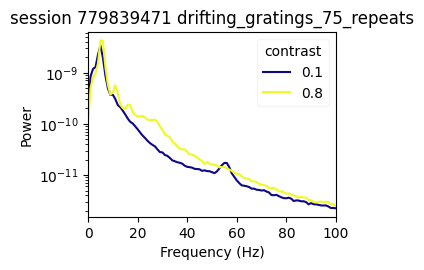

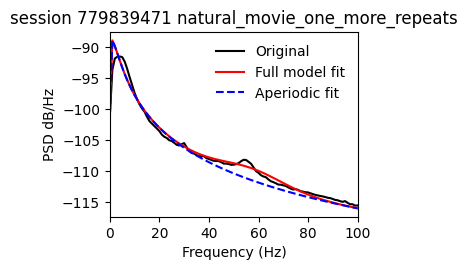

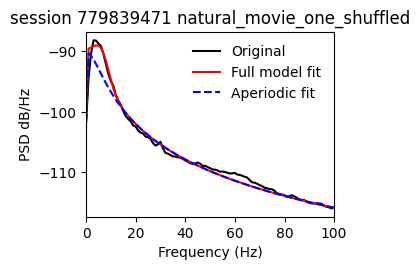

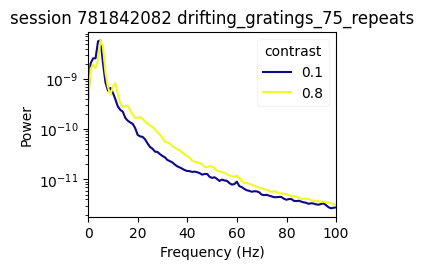

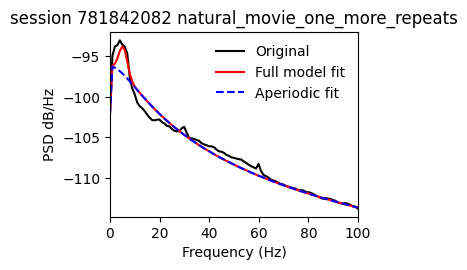

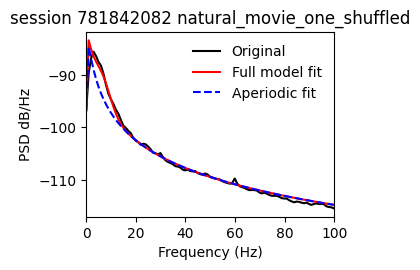

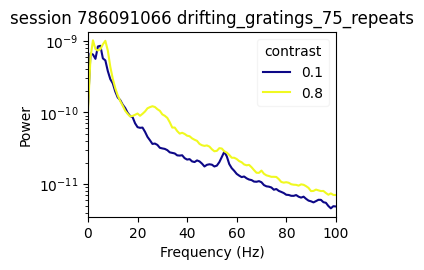

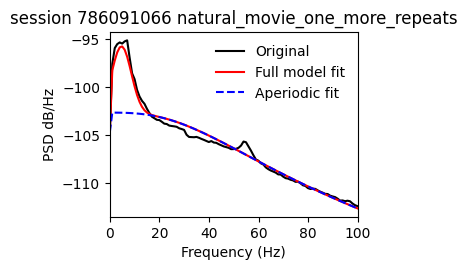

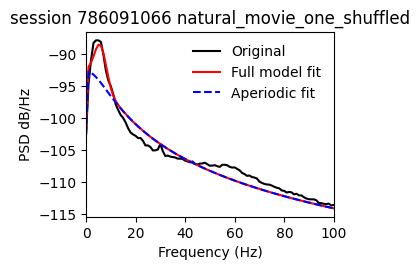

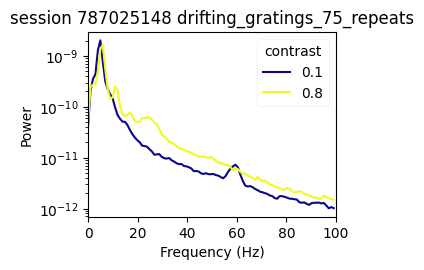

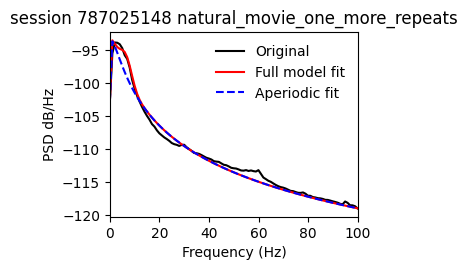

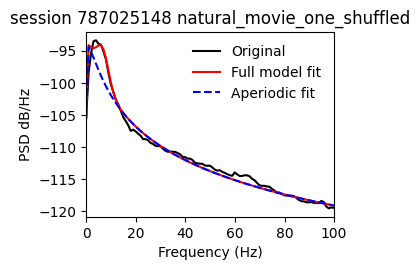

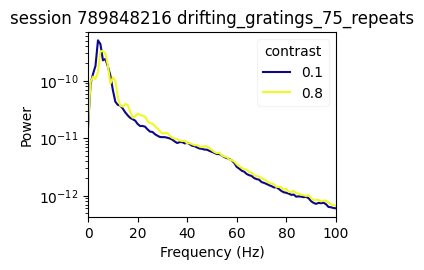

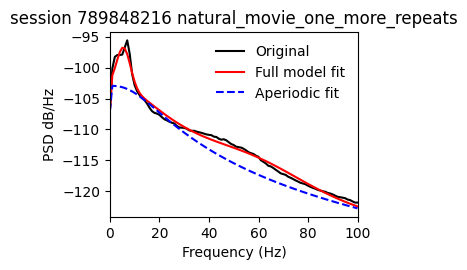

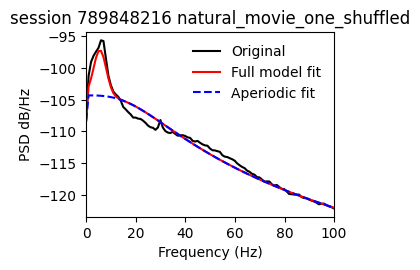

c:\Users\ziaochen\AppData\Local\anaconda3\envs\neuro\lib\site-packages\fooof\core\funcs.py:62: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


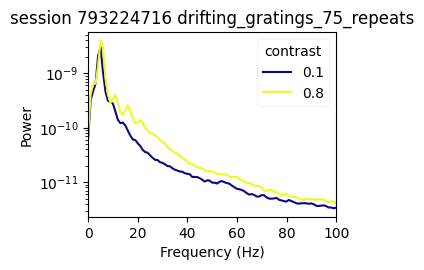

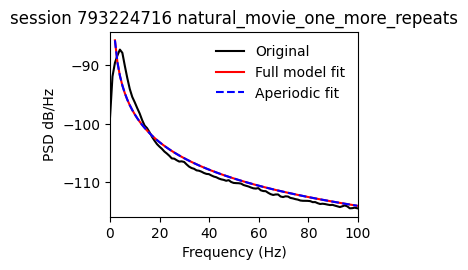

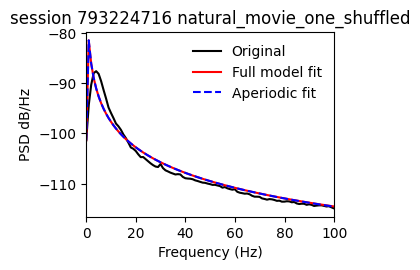

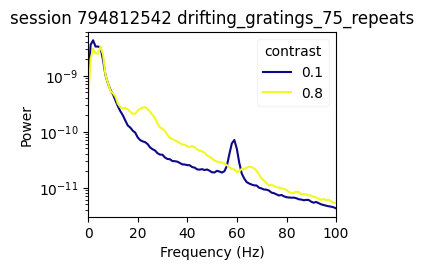

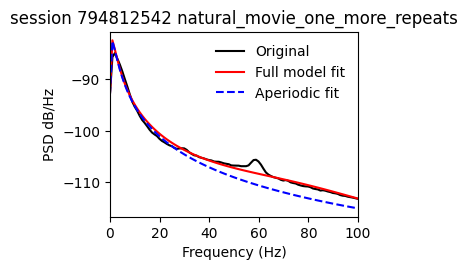

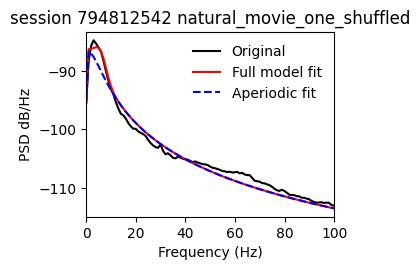

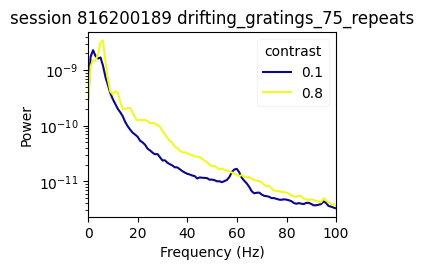

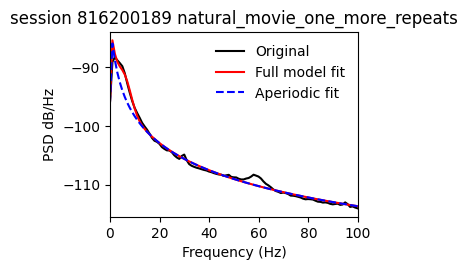

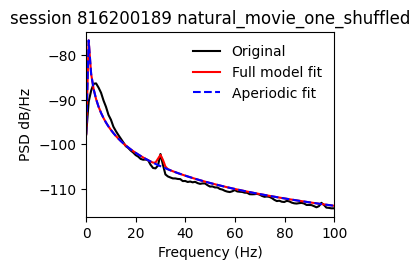

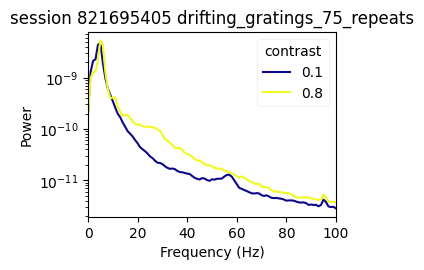

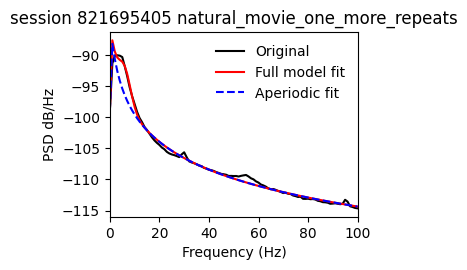

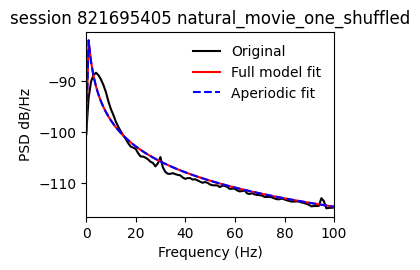

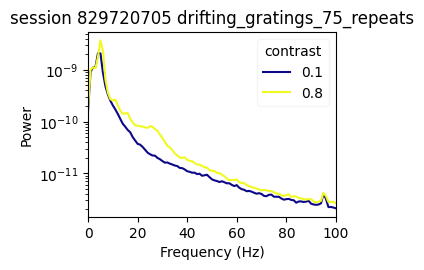

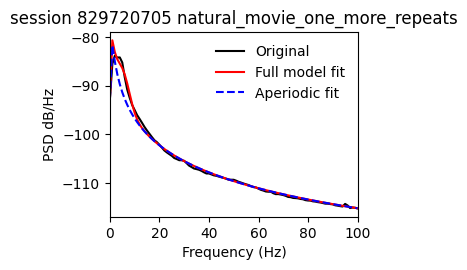

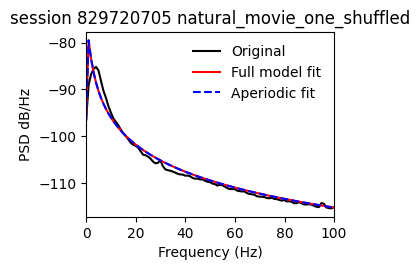

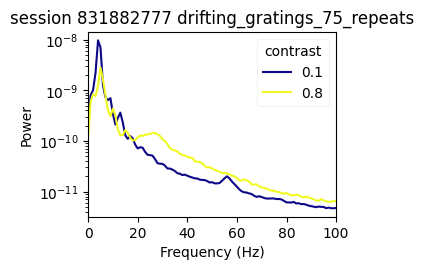

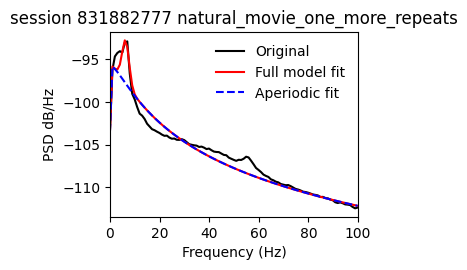

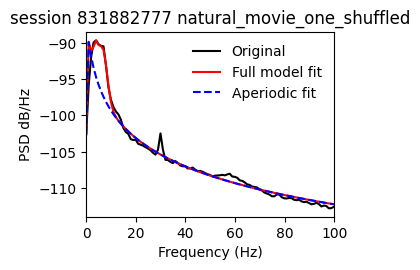

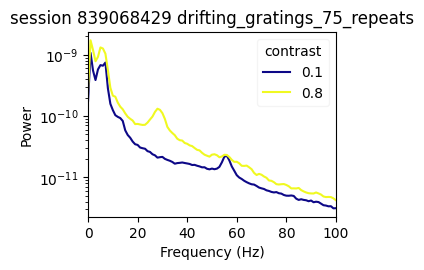

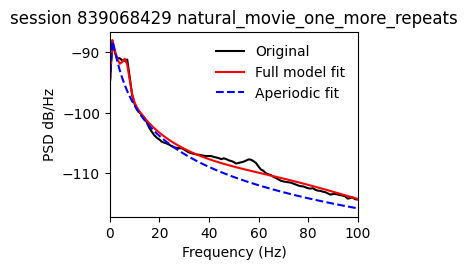

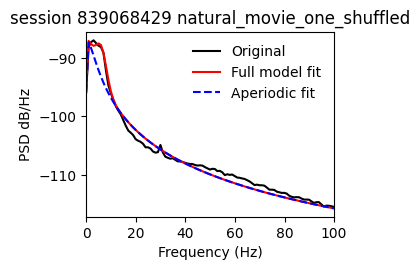

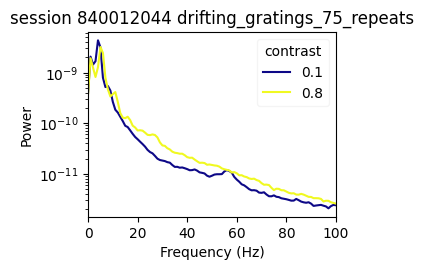

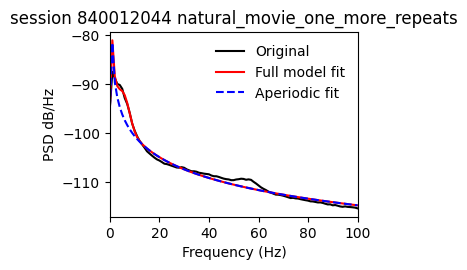

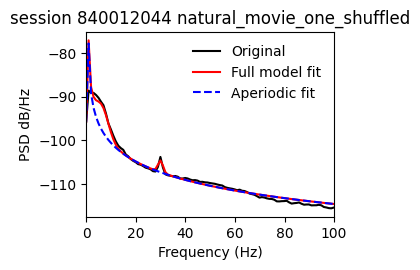

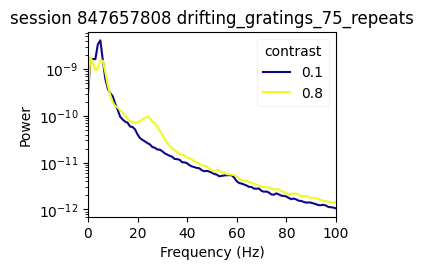

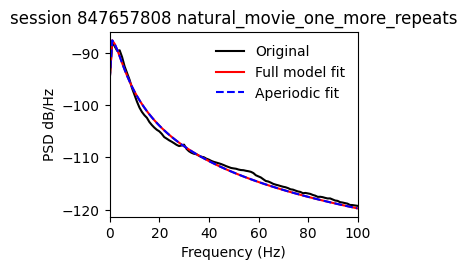

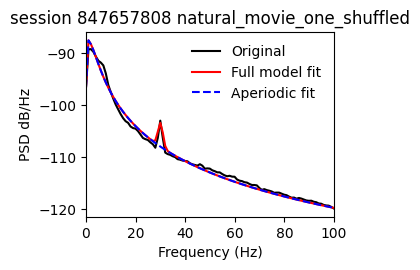

In [32]:
session_type_filter = ['functional_connectivity']
stimuli = [['drifting_gratings', 'drifting_gratings_75_repeats'],
           ['natural_movie_three', 'natural_movie_one', 'natural_movie_one_more_repeats', 'natural_movie_one_shuffled']]

for session_id in dg_cond_psd_ds.keys():
    if session_selection.loc[session_id, 'session_type'] not in session_type_filter:
        continue
    for i, stim_ds in enumerate([dg_cond_psd_ds, psd_ds]):
        ds = stim_ds[session_id]
        group_id = ds.attrs['center_unit_group_id']
        ds = ds.sel(channel=group_id)
        for stim, da in ds.items():
            if stim not in stimuli[i]:
                continue
            freq_coord = f'frequency_{stim:s}'
            da = da.rename({freq_coord: 'frequency'})
            if i == 0:
                cond_coord = next(iter(set(da.dims).difference(['channel', 'frequency'])))
                cond_name = cond_coord.replace(f'_{stim:s}', '')
                _, fig, _ = plot_channel_psd(da, channel_coord=cond_coord, channel_name=cond_name,
                                            freq_range=freq_range, plt_range=plt_range, figsize=figsize,
                                            aperiodic_mode=aperiodic_mode, dB_threshold=dB_threshold, max_n_peaks=max_n_peaks, plt_log=True)
            else:
                fooof_result = fit_fooof(da.frequency.values, da.values,
                    aperiodic_mode=aperiodic_mode, dB_threshold=dB_threshold, max_n_peaks=max_n_peaks,
                    freq_range=freq_range, peak_width_limits=None, report=False, plot=False)

                fig, ax = plt.subplots(figsize=figsize)
                psd_avg_plt = da.sel(frequency=slice(*plt_range))
                _ = plot_fooof(psd_avg_plt.frequency.values, psd_avg_plt.values, fooof_result[0], plt_log=False, plt_range=plt_range, plt_db=True, ax=ax)
            fig.get_axes()[0].set_title(f'session {session_id:d} {stim:s}')
    plt.show()

#### Average over sessions


drifting_gratings: 18 sessions


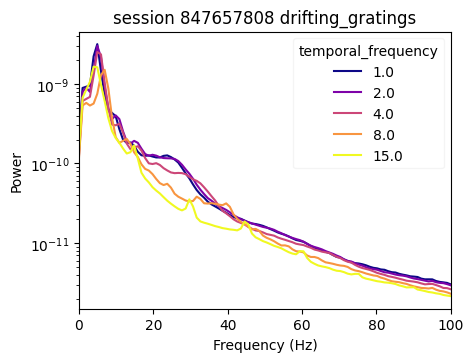


drifting_gratings_75_repeats: 21 sessions


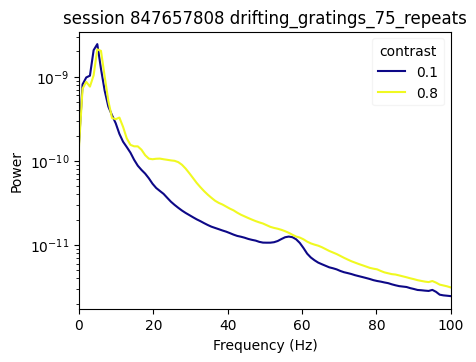


drifting_gratings_contrast: 21 sessions


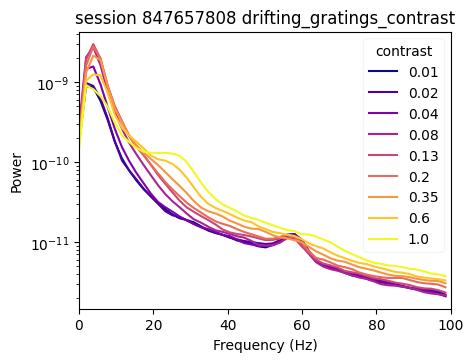

In [24]:
stimuli = ['drifting_gratings', 'drifting_gratings_75_repeats', 'drifting_gratings_contrast']

for stim in stimuli:
    psd_avg = average_across_sessions(dg_cond_psd_ds, stim)
    if psd_avg is None:
        continue

    cond_coord = next(iter(set(psd_avg.dims).difference(['frequency'])))
    cond_name = cond_coord.replace(f'_{stim:s}', '')
    _, fig1, _ = plot_channel_psd(psd_avg, channel_coord=cond_coord, channel_name=cond_name,
                                  freq_range=freq_range, plt_range=plt_range, figsize=np.array(figsize) * 1.5,
                                  aperiodic_mode=aperiodic_mode, dB_threshold=dB_threshold, max_n_peaks=max_n_peaks, plt_log=True)
    fig1.get_axes()[0].set_title(f'session {session_id:d} {stim:s}')
    plt.show()

### Show PSD of stimuli

#### Filter drifting grating conditions

In [ ]:
# contrast_filter = lambda x: x > 0.5
# tempfreq_filter = lambda x: x < 5

# condition_filters = dict(
#     contrast_drifting_gratings_contrast = contrast_filter,
#     contrast_drifting_gratings_75_repeats = contrast_filter,
#     temporal_frequency_drifting_gratings = tempfreq_filter
# )

# dg_cond_psd_ds[719161530]
# dg_cond_psd_ds[847657808]

#### Select stimuli

In [9]:
stimuli = ['drifting_gratings', 'natural_movie_three', 'natural_movie_one',
           'drifting_gratings_75_repeats', 'drifting_gratings_contrast',
           'natural_movie_one_more_repeats', 'natural_movie_one_shuffled']

#### Calculate average PSD


drifting_gratings: 18 sessions
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 0.99 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    -7.0090, 117.5922, 2.2623                                     
                                                                                                  
                                       1 peaks were found:                   

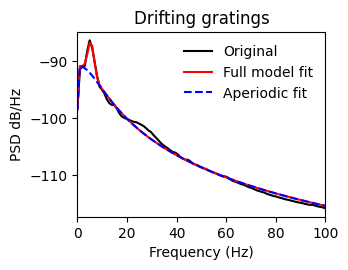


drifting_gratings_75_repeats: 21 sessions
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 0.99 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.2377, 59.4595, 2.1386                                     
                                                                                                  
                                       1 peaks were found:        

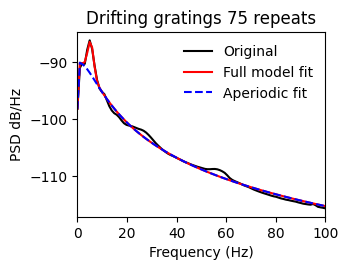


drifting_gratings_contrast: 21 sessions
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 199 Hz                        
                                 Frequency Resolution is 1.93 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.3967, 1.7547, 2.0829                                      
                                                                                                  
                                       0 peaks were found:          

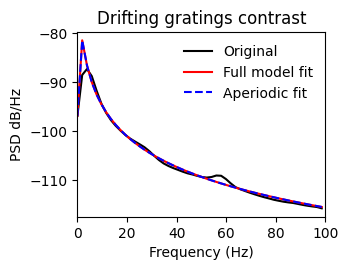

In [ ]:
for stim in stimuli:
    psd_avg = average_across_sessions(psd_ds, stim)
    if psd_avg is None:
        continue

    fooof_result = fit_fooof(psd_avg.frequency.values, psd_avg.values,
        aperiodic_mode=aperiodic_mode, dB_threshold=dB_threshold, max_n_peaks=max_n_peaks,
        freq_range=freq_range, peak_width_limits=None, report=True, plot=False)

    fig, ax = plt.subplots(figsize=figsize)
    psd_avg_plt = psd_avg.sel(frequency=slice(*plt_range))
    _ = plot_fooof(psd_avg_plt.frequency.values, psd_avg_plt.values, fooof_result[0], plt_log=False, plt_range=plt_range, plt_db=True, ax=ax)
    ax.set_title(stim.replace('_', ' ').capitalize())
    plt.show()